In [42]:
from sympy import *
init_printing()

In [43]:
R = Symbol("R", positive=True, real=True)
a, b = symbols("a b", real=True)
v = (a+b)/2
i = (a-b)/(2*R)

In [44]:
diode_expr = lambda isat, n, vt: lambda v: isat*(exp(v/(n*vt))-1)

def diode_eq(isat, n, vt, M, N):
    id = diode_expr(isat, n, vt)
    return lambda i, v: Eq(i, id(v/M) - id(-v/N))

isat, n, vt = symbols("i_sat n v_T", real=True, positive=True)
M, N = symbols("M N", integer=True, positive=True)
diode_eq(isat, n, vt, M, N)(v, i)

In [104]:
from newtonrhapson import NRSymbolic
from ipywidgets import FloatSlider, IntSlider, interact
import numpy as np
import matplotlib.pyplot as plt

def clamp(x, a, b):
    return np.where(x < a, a, np.where(x > b, b, x))

inp = np.linspace(-4, 4, 1000)
@interact(r=FloatSlider(min=130, max=350, step=0.1), nf=IntSlider(min=1, max=5), nb=IntSlider(min=1, max=5))
def cell(r: float, nf: int, nb: int):
    nr = NRSymbolic(a, b, diode_eq(200e-9, 2.109, 23e-3, nf, nb)(i, v).subs({R: r}), tol=1e-4)
    initial = clamp(2*inp, -nb, nf) - inp
    out = nr(inp, initial=initial)
    plt.grid(True, which="both")
    plt.tight_layout()
    plt.plot(inp, out)
    plt.plot(inp, initial, '--')
    #plt.plot(inp, -inp - nb, '--')
    #plt.plot(inp, -inp + nf, '--')

interactive(children=(FloatSlider(value=130.0, description='r', max=350.0, min=130.0), IntSlider(value=1, desc…

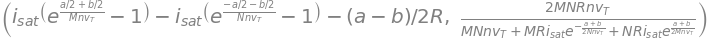

In [63]:

nr = NRSymbolic(a, b, diode_eq(isat, n, vt, M, N)(i, v))
nr.iteration, nr.inv_differential

In [64]:
def print_code(expr: Expr):
    vars, e = cse(expr.n())
    for name, expr in vars:
        yield rust_code(expr, name)
    result = rust_code(e)
    if isinstance(result, str):
        yield result
    else:
        yield from result

print(*print_code(nr.iteration), sep="\n")

x0 = (1_f64/2.0)*a + (1_f64/2.0)*b;
x1 = 1/(n*v_T);
[-i_sat*(-1.0 + (-x0*x1/N).exp()) + i_sat*((x0*x1/M).exp() - 1.0) - 0.5*(a - b)/R]


In [65]:
print(*print_code(nr.inv_differential), sep="\n")

x0 = M*N*n*v_T;
x1 = (1_f64/2.0)*(a + b)/(n*v_T);
x2 = R*i_sat;
[2.0*R*x0/(M*x2*(-x1/N).exp() + N*x2*(x1/M).exp() + x0)]
